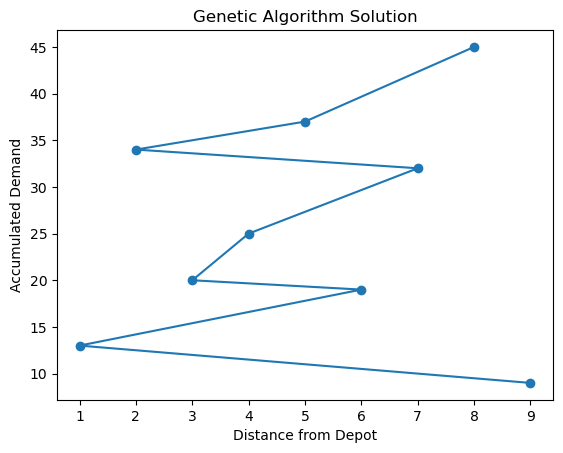

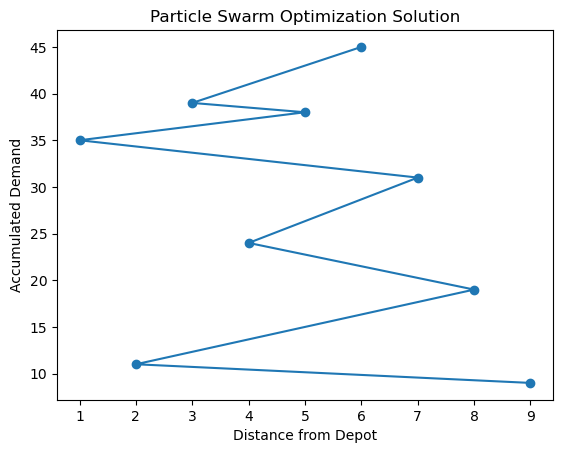

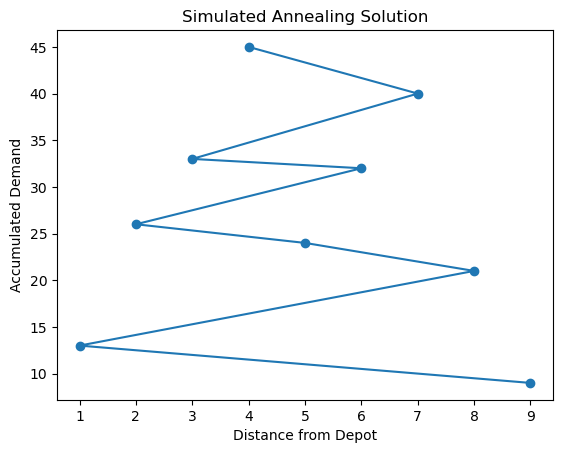

Genetic Algorithm:
  Best Solution: [9 1 6 3 4 7 2 5 8]
  Fitness: 0.0036629303070486972
  Execution Time: 0.7550153732299805

Particle Swarm Optimization:
  Best Solution: [9, 2, 8, 4, 7, 1, 5, 3, 6]
  Fitness: 0.0037080179807485797
  Execution Time: 0.12173962593078613

Simulated Annealing:
  Best Solution: [9 1 8 5 2 6 3 7 4]
  Fitness: 0.003735275136453796
  Execution Time: 4.532765865325928


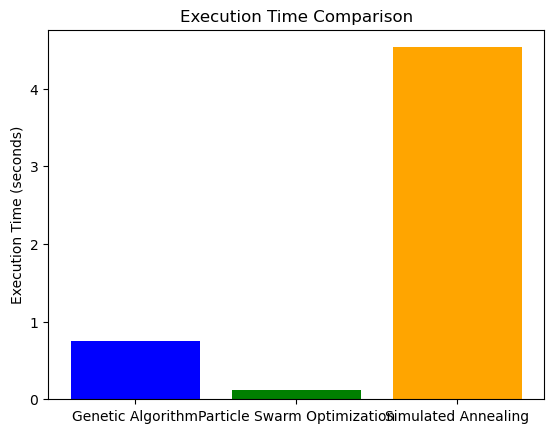

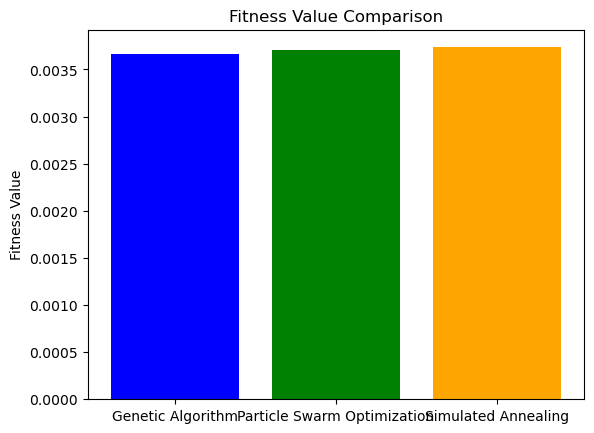

In [5]:
import numpy as np
import copy
import math
import random
import matplotlib.pyplot as plt
import time

# Constants for Genetic Algorithm
C_large = np.array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                    [1, 0, 10, 11, 12, 13, 14, 15, 16, 17],
                    [2, 10, 0, 18, 19, 20, 21, 22, 23, 24],
                    [3, 11, 18, 0, 25, 26, 27, 28, 29, 30],
                    [4, 12, 19, 25, 0, 31, 32, 33, 34, 35],
                    [5, 13, 20, 26, 31, 0, 36, 37, 38, 39],
                    [6, 14, 21, 27, 32, 36, 0, 40, 41, 42],
                    [7, 15, 22, 28, 33, 37, 40, 0, 43, 44],
                    [8, 16, 23, 29, 34, 38, 41, 43, 0, 45],
                    [9, 17, 24, 30, 35, 39, 42, 44, 45, 0]])

demand_large = [0, 4, 2, 1, 5, 3, 6, 7, 8, 9]
capacity_large = 30

population_size = 50
generations = 100

# Constants for Particle Swarm Optimization
num_particles = 20
max_iter = 100

# Constants for Simulated Annealing
initial_temperature_large = 1000
cooling_rate_large = 0.99
iterations_per_temperature_large = 100

# --- Genetic Algorithm ---

def initialize_population(population_size, num_customers):
    return [np.random.permutation(num_customers - 1) + 1 for _ in range(population_size)]

def fitness(solution, distance_matrix, demand, capacity, alpha=1.0, beta=1.0, gamma=1.0):
    total_distance = 0
    vehicle_workloads = [0] * (len(solution) + 1)  # Initialize workloads for each vehicle, including depot
    capacity_violation = 0

    for i in range(len(solution)):
        customer = solution[i]
        next_customer = solution[(i + 1) % len(solution)]

        total_distance += distance_matrix[customer][next_customer]
        vehicle_workloads[next_customer] = vehicle_workloads[customer] + demand[next_customer]

        # Update capacity violation
        if vehicle_workloads[next_customer] > capacity:
            capacity_violation += vehicle_workloads[next_customer] - capacity

    # Calculate workload imbalance (standard deviation of workloads)
    workload_imbalance = np.std(vehicle_workloads[1:-1])  # Exclude depot from imbalance calculation

    # Calculate fitness using the provided formula
    fitness_value = alpha * total_distance + beta * workload_imbalance + gamma * capacity_violation

    return 1 / (fitness_value + 1)  # Return the inverse as it's a minimization problem


def select_parents(population, fitness_values):
    total_fitness = sum(fitness_values)

    if np.isnan(total_fitness) or total_fitness == 0:
        return population[np.argmax(fitness_values)], population[np.argmax(fitness_values)]

    probabilities = fitness_values / total_fitness
    probabilities[np.isnan(probabilities)] = np.finfo(float).eps

    selected_indices = np.random.choice(np.arange(len(population)), size=2, p=probabilities)
    selected_parents = [population[index] for index in selected_indices]

    return selected_parents

def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, len(parent1) - 1)
    child1 = np.concatenate((parent1[:crossover_point], np.setdiff1d(parent2, parent1[:crossover_point])))
    child2 = np.concatenate((parent2[:crossover_point], np.setdiff1d(parent1, parent2[:crossover_point])))
    return child1, child2

def mutate(solution):
    mutation_point1, mutation_point2 = np.random.choice(len(solution), size=2, replace=False)
    solution[mutation_point1], solution[mutation_point2] = solution[mutation_point2], solution[mutation_point1]
    return solution

def genetic_algorithm(distance_matrix, demand, capacity, population_size, generations):
    num_customers = len(demand)
    population = initialize_population(population_size, num_customers)

    for generation in range(generations):
        fitness_values = np.array([fitness(sol, distance_matrix, demand, capacity) for sol in population])
        parents = [select_parents(population, fitness_values) for _ in range(population_size // 2)]

        children = []
        for parent1, parent2 in parents:
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            children.extend([child1, child2])

        population = children

    best_solution = max(population, key=lambda sol: fitness(sol, distance_matrix, demand, capacity))
    return best_solution

# --- Particle Swarm Optimization ---


w = 0.5  # Inertia weight
c1 = 2.0  # Cognitive parameter
c2 = 2.0  # Social parameter

def initialize_particles(num_particles, num_customers):
    return [{'position': np.random.permutation(num_customers - 1) + 1,
             'velocity': np.random.rand(num_customers - 1),
             'fitness': 0,
             'best_position': None,
             'best_fitness': float('-inf')} for _ in range(num_particles)]

def update_particle(particle, best_particle, global_best, w, c1, c2):
    inertia = w * np.array(particle['velocity'])
    cognitive = c1 * np.random.rand() * (np.array(particle['best_position']) - np.array(particle['position']))
    social = c2 * np.random.rand() * (np.array(global_best['best_position']) - np.array(particle['position']))

    new_velocity = inertia + cognitive + social
    new_position = (np.argsort(new_velocity) + 1).tolist()  # Ensure depot is at the beginning

    return {'position': new_position,
            'velocity': new_velocity,
            'fitness': fitness(new_position, C_large, demand_large, capacity_large),
            'best_position': particle['best_position'],
            'best_fitness': particle['best_fitness']}

def particle_swarm_optimization(num_particles, max_iter):
    num_customers = len(demand_large)

    particles = initialize_particles(num_particles, num_customers)

    global_best = {'best_position': None, 'best_fitness': float('-inf')}

    for iteration in range(max_iter):
        for i in range(num_particles):
            current_particle = particles[i]

            if current_particle['fitness'] > current_particle['best_fitness']:
                current_particle['best_position'] = current_particle['position']
                current_particle['best_fitness'] = current_particle['fitness']

            if current_particle['fitness'] > global_best['best_fitness']:
                global_best['best_position'] = current_particle['position']
                global_best['best_fitness'] = current_particle['fitness']

        for i in range(num_particles):
            particles[i] = update_particle(particles[i], current_particle, global_best, w, c1, c2)

    return global_best['best_position']


# --- Simulated Annealing ---

def initialize_solution(num_customers):
    return np.random.permutation(num_customers - 1) + 1

def generate_neighbor(solution):
    neighbor_solution = copy.deepcopy(solution)
    swap_indices = np.random.choice(len(solution), size=2, replace=False)
    neighbor_solution[swap_indices[0]], neighbor_solution[swap_indices[1]] = neighbor_solution[swap_indices[1]], neighbor_solution[swap_indices[0]]
    return neighbor_solution

def simulated_annealing(distance_matrix, demand, capacity, initial_temperature, cooling_rate, iterations_per_temperature):
    current_solution = initialize_solution(len(demand))
    current_fitness = fitness(current_solution, distance_matrix, demand, capacity)

    best_solution = current_solution
    best_fitness = current_fitness

    temperature = initial_temperature

    while temperature > 1:
        for _ in range(iterations_per_temperature):
            neighbor_solution = generate_neighbor(current_solution)
            neighbor_fitness = fitness(neighbor_solution, distance_matrix, demand, capacity)

            if neighbor_fitness > current_fitness or random.uniform(0, 1) < math.exp((neighbor_fitness - current_fitness) / temperature):
                current_solution = neighbor_solution
                current_fitness = neighbor_fitness

                if current_fitness > best_fitness:
                    best_solution = current_solution
                    best_fitness = current_fitness

        temperature *= cooling_rate

    return best_solution

# --- Comparative Analytics ---

def run_genetic_algorithm(distance_matrix, demand, capacity, population_size, generations):
    start_time = time.time()
    best_solution = genetic_algorithm(distance_matrix, demand, capacity, population_size, generations)
    execution_time = time.time() - start_time
    return best_solution, execution_time

def run_particle_swarm_optimization(distance_matrix, demand, capacity, num_particles, max_iter):
    start_time = time.time()
    best_solution = particle_swarm_optimization(num_particles, max_iter)
    execution_time = time.time() - start_time
    return best_solution, execution_time

def run_simulated_annealing(distance_matrix, demand, capacity, initial_temperature, cooling_rate, iterations_per_temperature):
    start_time = time.time()
    best_solution = simulated_annealing(distance_matrix, demand, capacity, initial_temperature, cooling_rate, iterations_per_temperature)
    execution_time = time.time() - start_time
    return best_solution, execution_time

def evaluate_solution(solution, distance_matrix, demand, capacity):
    fitness_value = fitness(solution, distance_matrix, demand, capacity)
    return fitness_value

def plot_solution(solution, distance_matrix, demand, capacity, title):
    x = [0]  # x-coordinate (depot)
    y = [0]  # y-coordinate (depot)

    for customer in solution:
        x.append(distance_matrix[0][customer])
        y.append(distance_matrix[0][customer])

    x.append(0)  # Return to depot
    y.append(0)  # Return to depot

    plt.figure()
    plt.plot(x, y, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.show()

def plot_demand_vs_distance(solution, distance_matrix, demand, capacity, title):
    x = []  # Distance
    y = []  # Demand

    current_capacity = 0
    for customer in solution:
        current_capacity += demand[customer]
        x.append(distance_matrix[0][customer])
        y.append(current_capacity)

    plt.figure()
    plt.plot(x, y, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel('Distance from Depot')
    plt.ylabel('Accumulated Demand')
    plt.show()

def comparative_analytics():
    # Run Genetic Algorithm
    best_solution_genetic, time_genetic = run_genetic_algorithm(C_large, demand_large, capacity_large, population_size, generations)
    plot_demand_vs_distance(best_solution_genetic, C_large, demand_large, capacity_large, 'Genetic Algorithm Solution')

    # Run Particle Swarm Optimization
    best_solution_pso, time_pso = run_particle_swarm_optimization(C_large, demand_large, capacity_large, num_particles, max_iter)
    plot_demand_vs_distance(best_solution_pso, C_large, demand_large, capacity_large, 'Particle Swarm Optimization Solution')

    # Run Simulated Annealing
    best_solution_sa, time_sa = run_simulated_annealing(C_large, demand_large, capacity_large,
                                                        initial_temperature_large, cooling_rate_large, iterations_per_temperature_large)
    plot_demand_vs_distance(best_solution_sa, C_large, demand_large, capacity_large, 'Simulated Annealing Solution')

    # Evaluate solution quality
    fitness_genetic = evaluate_solution(best_solution_genetic, C_large, demand_large, capacity_large)
    fitness_pso = evaluate_solution(best_solution_pso, C_large, demand_large, capacity_large)
    fitness_sa = evaluate_solution(best_solution_sa, C_large, demand_large, capacity_large)

    # Display results
    print("Genetic Algorithm:")
    print("  Best Solution:", best_solution_genetic)
    print("  Fitness:", fitness_genetic)
    print("  Execution Time:", time_genetic)

    print("\nParticle Swarm Optimization:")
    print("  Best Solution:", best_solution_pso)
    print("  Fitness:", fitness_pso)
    print("  Execution Time:", time_pso)

    print("\nSimulated Annealing:")
    print("  Best Solution:", best_solution_sa)
    print("  Fitness:", fitness_sa)
    print("  Execution Time:", time_sa)

    # Generate bar chart for execution times
    algorithms = ['Genetic Algorithm', 'Particle Swarm Optimization', 'Simulated Annealing']
    execution_times = [time_genetic, time_pso, time_sa]

    plt.bar(algorithms, execution_times, color=['blue', 'green', 'orange'])
    plt.ylabel('Execution Time (seconds)')
    plt.title('Execution Time Comparison')
    plt.show()

    # Generate bar chart for fitness values
    fitness_values = [fitness_genetic, fitness_pso, fitness_sa]

    plt.bar(algorithms, fitness_values, color=['blue', 'green', 'orange'])
    plt.ylabel('Fitness Value')
    plt.title('Fitness Value Comparison')
    plt.show()

comparative_analytics()
